In [ ]:
import requests
import pandas
#https://github.com/hozn/stravalib
from stravalib.client import Client
import json
import pandas as pd
import datetime

### REGISTER NEW STRAVA APPLICATION
Follow the steps here https://developers.strava.com/docs/getting-started/#account

### GENERATE ACCESS TOKEN (one time only)
Update **config.properties** file and set CLIENT_ID & CLIENT_SECRET from My API Application webpage https://www.strava.com/settings/api

In [ ]:
import configparser

config_parser = configparser.RawConfigParser()
config_parser.read('config.properties')

config = dict(config_parser.items('STRAVA'))

CLIENT_ID = config['client_id']
CLIENT_SECRET = config['client_secret']

In [ ]:
# see all scopes here https://developers.strava.com/docs/authentication/ 
SCOPE = 'activity:read_all'
REDIRECT_URL = 'http://localhost/authorization' # use localhost to generate dev token

In [ ]:
def generate_authorization_url(client_id, redirect_url, scope):
    return f"""https://www.strava.com/oauth/authorize?client_id={client_id}&redirect_uri={REDIRECT_URL}&approval_prompt=auto&response_type=code&scope={scope}"""

url = generate_authorization_url(CLIENT_ID, REDIRECT_URL, SCOPE)
print(url)

- Open the link above
- click **Authorize** which will redirect you to 'This site can’t be reached'
- copy **code** parameter from the url and paste it below

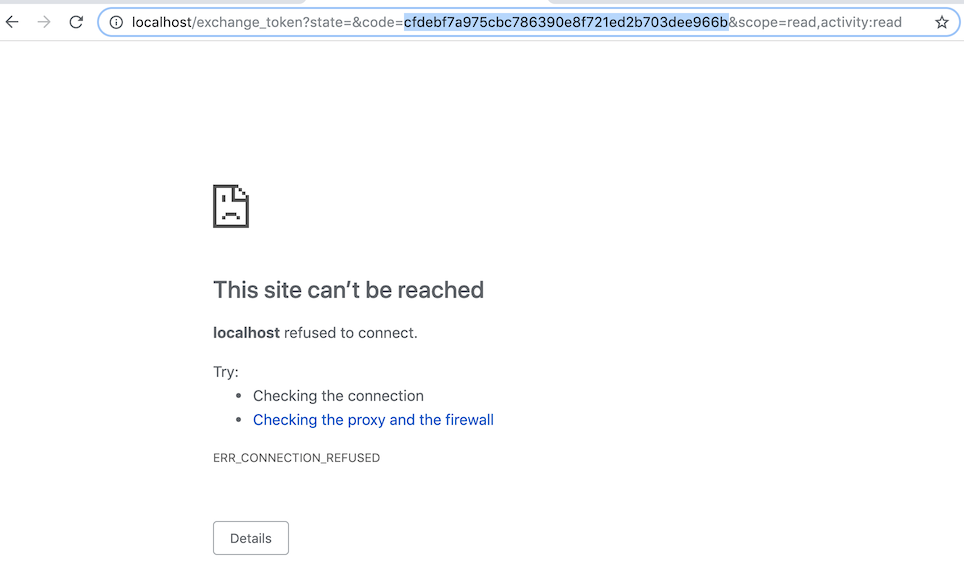

See more details here https://developers.strava.com/docs/getting-started/#account

In [ ]:
CODE = ''

- generate access_token and save it to file for future use. Code can be used only once

In [ ]:
client = Client()
generated_token = client.exchange_code_for_token(client_id=CLIENT_ID,
                                              client_secret=CLIENT_SECRET,
                                              code=CODE)
generated_token

In [ ]:
with open('access_token.json', 'w') as f:
    json.dump(generated_token, f)

### Strava Clubs API Calls

In [ ]:
with open('access_token.json', 'r') as f:
    token = json.loads(f.read())
    
access_token = token['access_token']
client = Client(access_token=access_token)

In [ ]:
# get your name
athlete = client.get_athlete()
print("Hello, {}".format(athlete.firstname))

In [ ]:
client.get_athlete_clubs()

- pick club id from the list above

In [ ]:
CLUB_ID =  

In [ ]:
def get_club_activities(club_id):

    def get_data(row):
        return [
            row['athlete']['firstname'],
            row['type'],
            row['start_date_local'],
            row['distance'],
            row['elapsed_time'],
            row['total_elevation_gain']
        ]  
    
    activities = client.get_club_activities(club_id)
    
    data = []
    for activity in activities:
        my_dict = activity.to_dict()
        data.append(get_data(my_dict))
        
    return pd.DataFrame(data, columns=['athlete','type','date','distance','time','elevation'])

In [ ]:
df = get_club_activities(CLUB_ID)
df.head

In [ ]:
def to_seconds(time):
    date_time = datetime.datetime.strptime(time, "%H:%M:%S") - datetime.datetime(1900, 1, 1)
    return date_time.total_seconds()

df['distance_km'] = df['distance']/1000
df['time_seconds'] = df.apply(lambda x: to_seconds(x['time']), axis=1)
df

API does not return activity date but activities are ordered so I'm removing everything from my last decemeber activity that I found manually on Clubs Recent Activity page

In [ ]:
last_dec_activity = ('Marcin','15108.8','0:33:05')

In [ ]:
index = df.query(f'distance == {last_dec_activity[1]}').index[0]
df = df.head(n=index)

### Totals for all althletes

In [ ]:
def seconds_to_time(seconds):
    return str(datetime.timedelta(seconds=seconds)) 

total_distance = df['distance_km'].sum()
total_time = seconds_to_time(df['time_seconds'].sum())
print(f'Total Distance: {total_distance:.2f}km')
print(f'Total Time: {total_time}')

In [ ]:
grouped = df.groupby(by=['athlete'], as_index=False).agg({'distance_km': ['sum'], 'time_seconds': ['sum']})
grouped.columns = grouped.columns.droplevel(1)
grouped['time'] = grouped.apply(lambda x: seconds_to_time(x['time_seconds']), axis=1)

In [ ]:
grouped

In [ ]:
grouped.sort_values(['distance_km'],ascending=0)

In [ ]:
grouped.sort_values(['time_seconds'],ascending=0)

In [ ]:
grouped2 = df.groupby(by=['athlete','type'], as_index=False).agg({'distance_km': ['sum'], 'time_seconds': ['sum']})
grouped2.columns = grouped2.columns.droplevel(1)
grouped2['time'] = grouped2.apply(lambda x: seconds_to_time(x['time_seconds']), axis=1)
grouped2